In [1]:
from __future__ import print_function
import anndata as ad
import numpy as np
import pandas as pd
import logging
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import random

import anndata as ad
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

import plotly.io as plt_io
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
from sklearn.metrics import mean_squared_error
from tensorflow import keras

from keras.models import Model
from keras.layers import Dense, Input
from keras.regularizers import l1
from tensorflow.keras.optimizers import Adam 
import tensorflow as tf
tf.config.run_functions_eagerly(True)

import torch
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
#import torchvision
from sklearn.metrics.pairwise import euclidean_distances
from scipy import sparse
import math

In [2]:
adata_gex = ad.read_h5ad("cite_gex_processed_training.h5ad")
adata_adt = ad.read_h5ad("cite_adt_processed_training.h5ad")
train_cells = adata_gex.obs_names[adata_gex.obs["batch"] != "s1d2"]
test_cells  = adata_gex.obs_names[adata_gex.obs["batch"] == "s1d2"]
input_train_mod1 = adata_gex[train_cells]
input_train_mod2 = adata_adt[train_cells]
input_test_mod1 =  adata_gex[test_cells]
true_test_mod2 =  adata_adt[test_cells]

number_of_rows = input_train_mod1.X.shape[0]
random_indices = np.random.choice(number_of_rows, size=4000, replace=False)
gex_subset = input_train_mod1.X[random_indices, :]
adt_subset = input_train_mod2.X[random_indices, :]
y = input_train_mod2.X[random_indices, :].toarray()
cell_types_gex = input_train_mod1.obs.iloc[random_indices, :]['cell_type'].values
cell_types_adt = input_train_mod2.obs.iloc[random_indices, :]['cell_type'].values

In [3]:
def pairwise(code,curbatch):
    d_embedding = torch.pdist(code)
    d_org = torch.pdist(curbatch)
    los = nn.MSELoss()
    return los(d_embedding,d_org)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
coo = gex_subset.tocoo()
values = coo.data
indices = np.vstack((coo.row, coo.col))
i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo.shape
gex_torch_data = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense().to(device)

coo = adt_subset.tocoo()
values = coo.data
indices = np.vstack((coo.row, coo.col))
i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo.shape
adt_torch_data = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense().to(device)

In [5]:
def to_tensor(raw_data):
    coo = raw_data.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape
    converted_data = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()
    return converted_data

In [6]:
def normalize_data(gex_data):
    return torch.nn.functional.normalize(gex_data,p=2, dim=1)

In [7]:
gex_torch_data_norm = normalize_data(gex_torch_data)

In [8]:
class AE_coupled(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        # create layers
        # adt
        self.encoder_input_layer_adt = nn.Linear(in_features=134, out_features=100)
        self.encoder_layer64_adt = nn.Linear(in_features=100, out_features=64)
        self.encoder_layer32_adt= nn.Linear(in_features=64, out_features=32)
        
        self.decoder_layer32d_adt = nn.Linear(in_features=2, out_features=32)
        self.decoder_layer64d_adt = nn.Linear(in_features=32, out_features=64)
        self.decoder_layer100d_adt = nn.Linear(in_features=64, out_features=100)
        self.decoder_output_layer_adt = nn.Linear(in_features=100, out_features=134)
        
        #CODE LAYER
        self.encoder_layer_code = nn.Linear(in_features=32, out_features=2)
        
        #GEX
        self.encoder_input_layer_gex= nn.Linear(in_features=13953, out_features=10000)
        self.encoder_layer6000_gex= nn.Linear(in_features=10000, out_features=6000)
        self.encoder_layer3000_gex= nn.Linear(in_features=6000, out_features=3000)
        self.encoder_layer1000_gex= nn.Linear(in_features=3000, out_features=1000)
        self.encoder_layer256_gex= nn.Linear(in_features=1000, out_features=256)
        self.encoder_layer128_gex = nn.Linear(in_features=256, out_features=128)
        self.encoder_layer64_gex = nn.Linear(in_features=128, out_features=64)
        self.encoder_layer32_gex = nn.Linear(in_features=64, out_features=32)
        
        
        self.decoder_layer32d_gex = nn.Linear(in_features=2, out_features=32)
        self.decoder_layer64d_gex = nn.Linear(in_features=32, out_features=64)
        self.decoder_layer128d_gex = nn.Linear(in_features=64, out_features=128)
        self.decoder_layer256d_gex = nn.Linear(in_features=128, out_features=256)
        self.decoder_layer1000d_gex = nn.Linear(in_features=256, out_features=1000)
        self.decoder_layer3000d_gex = nn.Linear(in_features=1000, out_features=3000)
        self.decoder_layer6000d_gex = nn.Linear(in_features=3000, out_features=6000)
        self.decoder_layer10000d_gex = nn.Linear(in_features=6000, out_features=10000)
        self.decoder_output_layer_gex = nn.Linear(in_features=10000, out_features=13954)
        
    
    def adt_to_code(self,features):
        activation = self.encoder_input_layer_adt(features)
        activation = torch.relu(activation)
        activation = self.encoder_layer64_adt(activation)
        activation = torch.relu(activation)
        activation = self.encoder_layer32_adt(activation)
        activation = torch.relu(activation)
        code = self.encoder_layer_code(activation)
        return code
    
    def gex_to_code(self,features):
        activation = self.encoder_input_layer_gex(features)
        activation = self.encoder_layer6000_gex(activation)
        activation = torch.relu(activation)
        activation = self.encoder_layer3000_gex(activation)
        activation = torch.relu(activation)
        activation = self.encoder_layer1000_gex(activation)
        activation = torch.relu(activation)
        activation = self.encoder_layer256_gex(activation)
        activation = torch.relu(activation)
        activation = self.encoder_layer128_gex(activation)
        activation = torch.relu(activation)
        activation = self.encoder_layer64_gex(activation)
        activation = torch.relu(activation)
        activation = self.encoder_layer32_gex(activation)
        activation = torch.relu(activation)
        code = self.encoder_layer_code(activation)
        return code
    
    def code_to_adt(self,code):
        activation = torch.relu(code)
        activation = self.decoder_layer32d_adt(activation)
        activation = torch.relu(activation)
        activation = self.decoder_layer64d_adt(activation)
        activation = torch.relu(activation)
        activation = self.decoder_layer100d_adt(activation)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer_adt(activation)
        return activation
    def code_to_gex(self,code):
        activation = torch.relu(code)
        activation = self.decoder_layer32d_gex(activation)
        activation = torch.relu(activation)
        activation = self.decoder_layer64d_gex(activation)
        activation = torch.relu(activation)
        activation = self.decoder_layer128d_gex(activation)
        activation = torch.relu(activation)
        activation = self.decoder_layer256d_gex(activation)
        activation = torch.relu(activation)
        activation = self.decoder_layer1000d_gex(activation)
        activation = torch.relu(activation)
        activation = self.decoder_layer3000d_gex(activation)
        activation = torch.relu(activation)
        activation = self.decoder_layer6000d_gex(activation)
        activation = torch.relu(activation)
        activation = self.decoder_layer10000d_gex(activation)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer_gex(activation)
        return activation
    
    def un_norm_gex(self,gex_output):
        main_chunk = gex_output[:, :13953]
        scale_col = gex_output[:, 13953:13954]
        return main_chunk*scale_col
    
    def norm_batch(self, batch_gex):
        gex_torch_data_norm = torch.nn.functional.normalize(batch_gex,p=2, dim=1)
        return gex_torch_data_norm
    
    def forward(self, features,to_adt):
        # encode
        num_dim = features.shape[1]
        if num_dim == 134:
            code= self.adt_to_code(features)
        elif num_dim==13953:
            
            code= self.gex_to_code((features))
        else:
            return "invalid input"
        
        
        
        output_layer_adt = self.code_to_adt(code)
        output_layer_gex = self.code_to_gex(code)
        
        output_layer_gex = self.un_norm_gex(output_layer_gex)
        
        
        
        return code,output_layer_adt,output_layer_gex
        

In [9]:
model_coupled = (AE_coupled()).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer_gex = optim.Adam(model_coupled.parameters(), lr=1e-3)

criterion_mse = nn.MSELoss()
criterion_pairwise = pairwise

In [10]:
train_loss_mse_gex_list = []
train_loss_mse_adt_list = []
train_loss_pairwise_gex_list = []
train_loss_pairwise_adt_list = []
train_loss_latent_mse = []
cross_to_adt = []
cross_to_gex = []
un_norm_loss= []
epoch_gex = []
epoch_adt = []

In [11]:
x,y = [],[]
num_points =gex_torch_data.shape[0]
batch_size = 100
for epoch in range(50):
    loss = 0
    permutation = torch.randperm(gex_torch_data.shape[0])
    
    for i in range(0,num_points,batch_size):
        indices = permutation[i:i+batch_size]
        cur_batch_gex = gex_torch_data_norm[indices]
        cur_batch_adt = adt_torch_data[indices]
        org_cur_batch = gex_torch_data[indices]
        optimizer_gex.zero_grad()
        
    
        
        
        
        #get predictions
        code_output_gex,outputs_gex_adt,outputs_gex_gex = model_coupled(cur_batch_gex,False)
        code_output_adt,outputs_adt_adt, outputs_adt_gex = model_coupled(cur_batch_adt,True)
        
        
        #train_loss mse
        train_loss_mse_gex = criterion_mse(outputs_gex_gex, org_cur_batch)*0.001
        train_loss_mse_adt = criterion_mse(outputs_adt_adt, cur_batch_adt)
        
    
        #train_loss pairwise
        train_loss_pairwise_gex = criterion_pairwise(code_output_gex,cur_batch_gex)
        train_loss_pairwise_adt = criterion_pairwise(code_output_adt,cur_batch_adt)
        
        #train loss cross modal
        loss_adt_to_gex = criterion_mse(outputs_adt_gex,org_cur_batch)
        loss_gex_to_adt = criterion_mse(outputs_gex_adt,cur_batch_adt)
        #+loss_adt_to_gex+loss_gex_to_adt
        
        #train loss cross modal latent space
        loss_mse_latent = criterion_mse(code_output_adt,code_output_gex)
        
        
        #add lists
        train_loss_mse_gex_list.append(train_loss_mse_gex.item())
        train_loss_mse_adt_list.append(train_loss_mse_adt.item())
        train_loss_pairwise_gex_list.append(train_loss_pairwise_gex.item())
        train_loss_pairwise_adt_list.append(train_loss_pairwise_adt.item())
        train_loss_latent_mse.append(loss_mse_latent.item())
        cross_to_adt.append(loss_gex_to_adt.item())
        cross_to_gex.append(loss_adt_to_gex.item())
        
        #final train loss
        train_loss = (train_loss_mse_adt+train_loss_mse_gex+
                      loss_mse_latent+train_loss_pairwise_gex+train_loss_pairwise_adt+
                      +loss_adt_to_gex+loss_gex_to_adt)
        
        train_loss.backward()
    
        optimizer_gex.step()
        loss += train_loss.item()
    
    loss = loss / num_points
    
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, 5, loss))
    x.append(loss)
    y.append(epoch+1)

epoch : 1/5, loss = 1917.198818
epoch : 2/5, loss = 1896.882773
epoch : 3/5, loss = 1894.999351
epoch : 4/5, loss = 1858.971548
epoch : 5/5, loss = 1899.024214
epoch : 6/5, loss = 1838.146676
epoch : 7/5, loss = 1852.109529
epoch : 8/5, loss = 1713.156440
epoch : 9/5, loss = 1978.059766
epoch : 10/5, loss = 1910.332800
epoch : 11/5, loss = 1897.221687
epoch : 12/5, loss = 1868.821221
epoch : 13/5, loss = 1846.738845
epoch : 14/5, loss = 1844.706877
epoch : 15/5, loss = 1839.774502
epoch : 16/5, loss = 1841.176369
epoch : 17/5, loss = 1840.297249
epoch : 18/5, loss = 1847.337923
epoch : 19/5, loss = 1839.756699
epoch : 20/5, loss = 1839.286214
epoch : 21/5, loss = 1839.871699
epoch : 22/5, loss = 1839.235724
epoch : 23/5, loss = 1839.247454
epoch : 24/5, loss = 1848.056514
epoch : 25/5, loss = 1839.334807
epoch : 26/5, loss = 1842.773052
epoch : 27/5, loss = 1838.292599
epoch : 28/5, loss = 1841.363093
epoch : 29/5, loss = 1839.072901
epoch : 30/5, loss = 1841.459232
epoch : 31/5, loss 

Text(0.5, 0.98, 'ADT')

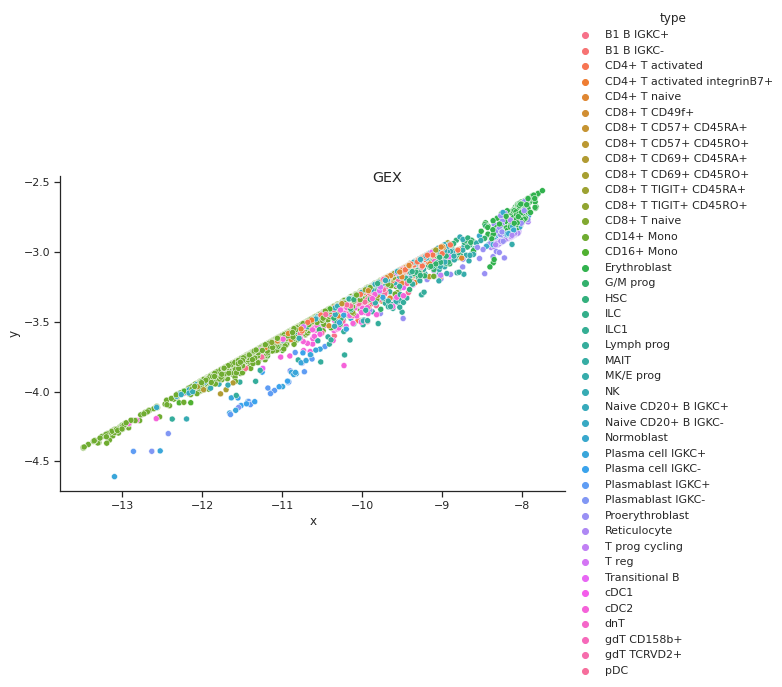

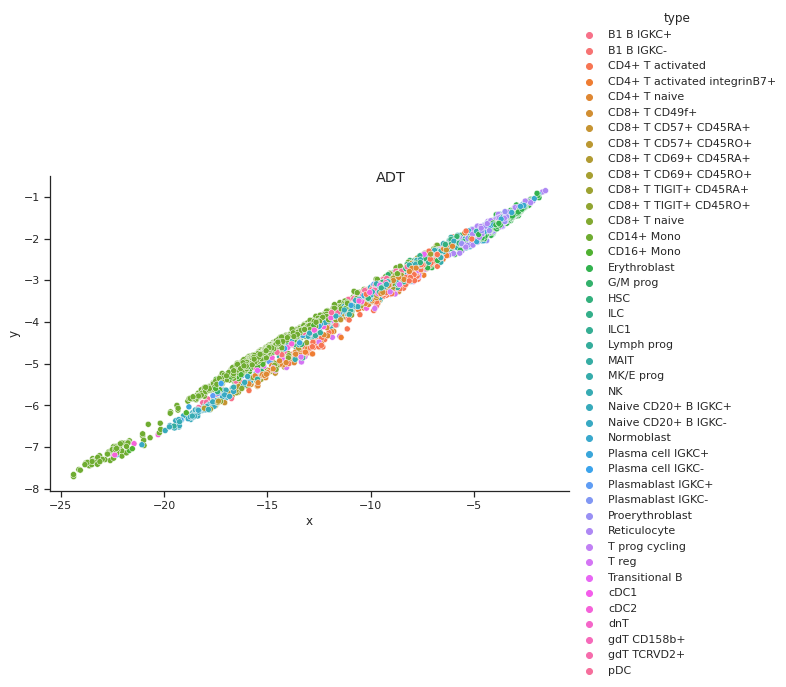

In [12]:
auto_latent_gex = ((model_coupled(gex_torch_data_norm,False)[0]))
df_gex = pd.DataFrame({'x':auto_latent_gex[:,0].cpu().detach().numpy(),
                       'y':auto_latent_gex[:,1].cpu().detach().numpy(),'type':cell_types_gex})
gex_plot = sns.relplot(data=df_gex, x='x', y='y', hue='type', aspect=1.61, )
gex_plot.fig.suptitle('GEX')

auto_latent_adt = model_coupled(adt_torch_data,True)[0]
df_adt = pd.DataFrame({'x':auto_latent_adt[:,0].cpu().detach().numpy(),
                       'y':auto_latent_adt[:,1].cpu().detach().numpy(),'type':cell_types_adt})
adt_plot = sns.relplot(data=df_adt, x='x', y='y', hue='type', aspect=1.61, )
adt_plot.fig.suptitle('ADT')

In [26]:
def output_RMSE():
    cpu_mod = model_coupled.cpu()
    test_gex = to_tensor(input_test_mod1.X)
    test_adt = to_tensor(true_test_mod2.X)
    test_gex_norm = normalize_data(test_gex)
    gex_code,gex_adt,gex_gex = cpu_mod(test_gex_norm,False)
    adt_code,adt_adt,adt_gex = cpu_mod(test_adt,False)
    adt_pred_loss = (nn.MSELoss()(test_adt,gex_adt))**0.5
    gex_pred_loss = (nn.MSELoss()(test_gex,adt_gex))**0.5
    
    print(  ' :adt_pred_loss :'+ str(adt_pred_loss))
    print( ' :gex_pred_loss :'+ str(gex_pred_loss))
    model_coupled.to(device)
    return gex_pred_loss,adt_pred_loss

In [25]:
output_RMSE()

 :adt_pred_loss :tensor(0.8890, grad_fn=<PowBackward0>)
 :gex_pred_loss :tensor(466.8170, grad_fn=<PowBackward0>)


(tensor(466.8170, grad_fn=<PowBackward0>),
 tensor(0.8890, grad_fn=<PowBackward0>),
 tensor([[-11.1717,  -3.6697],
         [-10.8297,  -3.5523],
         [-10.3649,  -3.3998],
         ...,
         [-13.2483,  -4.3344],
         [-10.9322,  -3.5832],
         [-12.2739,  -4.0107]], grad_fn=<AddmmBackward0>))

In [13]:
test_gex = to_tensor(input_test_mod1.X)
test_adt = to_tensor(true_test_mod2.X)

In [14]:
test_gex_norm = normalize_data(test_gex)

In [16]:
cpu_mod = model_coupled.cpu()

In [17]:
gex_code,gex_adt,gex_gex = cpu_mod(test_gex_norm,False)
adt_code,adt_adt,adt_gex = cpu_mod(test_adt,False)

In [18]:
(nn.MSELoss()(test_adt,gex_adt))**0.5

tensor(0.8392, grad_fn=<PowBackward0>)

In [19]:
(nn.MSELoss()(test_gex,adt_gex))**0.5

tensor(236.9968, grad_fn=<PowBackward0>)